In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import matplotlib.colors as mcolors
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
from scipy.ndimage import convolve
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [283]:
input_file_name = 'Data/WScFi4GeV28degrees.pkl'
output_file_name = 'Data/28deg_cali.pkl'

with open(input_file_name, 'rb') as file:
    dataframes_dict = pickle.load(file)
    
towers = np.array([12, 13, 14, 15, 8, 9, 10, 11, 4, 5, 6, 7, 0, 1, 2, 3])


In [284]:
def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def channel_to_xy(channel):
    # Validate the channel number
    if not (0 <= channel <= 15):
        raise ValueError("Channel number must be between 0 and 15.")
        
    tower_size = 25
    
    col = channel % 4
    row = channel // 4

    origin_offset = 2 * tower_size

    x = (col * tower_size + tower_size / 2) - origin_offset
    y = (row * tower_size + tower_size / 2) - origin_offset
    
    return (x, y)

def circular_kernel(radius):
    size = int(2 * radius + 1)
    kernel = np.zeros((size, size))
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius**2
    kernel[mask] = 1
    kernel = kernel / np.sum(kernel)  # Normalize the kernel
    return kernel


In [285]:
hod_df = dataframes_dict['hod_df']

# Select ADC values for all channels
adc_values = hod_df[[f'ch_{i + 48}' for i in range(16)]].values

# Calculate y multiplicity
ymult = np.sum(adc_values[:, :8] > 0, axis=1)

# Calculate x multiplicity
xmult = np.sum(adc_values[:, 8:] > 0, axis=1)

Sc1RawADCSpectrum = dataframes_dict['sc1_df']['ch_32']
Ce1RawADCSpectrum = dataframes_dict['ce1_df']['ch_35']
Ce2RawADCSpectrum = dataframes_dict['ce2_df']['ch_37']

# Initialize arrays
ElectronEcalCh = np.zeros((16, len(hod_df['ch_48'])))

# Calculate the ecut array
ecut = (Sc1RawADCSpectrum < 1000) & (xmult == 1) & (ymult == 1) & (Ce1RawADCSpectrum > 0) & (Ce1RawADCSpectrum < 300) & (Ce2RawADCSpectrum == 0)

for i in range(16):
    ElectronEcalCh[i] = dataframes_dict['ecal_df'][f'ch_{i+16}'] 

# Calculate ECalSum for all events
ECalSum = np.sum(ElectronEcalCh, axis=0)

# Indices to check
indices_to_check = [5, 6, 9, 10]

# Step 1: Find the maximum value in each sublist
max_values = np.max(ElectronEcalCh, axis=0)

# Step 2: Extract values at the specified indices
values_at_indices = ElectronEcalCh[indices_to_check]

# Step 3: Check if the max values are in the extracted values
is_max_at_indices = np.any(values_at_indices == max_values, axis=0)

# Calculate ECalMultiplicity for all events
ECalMultiplicity = np.sum(ElectronEcalCh > 10, axis=0)

# Update ecutMask
#ecutMask = ecut & (ECalMultiplicity >= 3) & is_max_at_indices
ecutMask = ecut & (ECalMultiplicity >= 3)

# Filter ECalSumElectron and ElectronEcalCh based on ecutMask
ECalSumElectron = ECalSum[ecutMask]
ElectronEcalCh = ElectronEcalCh[:, ecutMask]

Mean: 440.42801181316617
Mean Error: 0.07579653995297826
Resolution: 7.131691709903887
Resolution Error: 0.015191491607663444


Text(0, 1, 'Count')

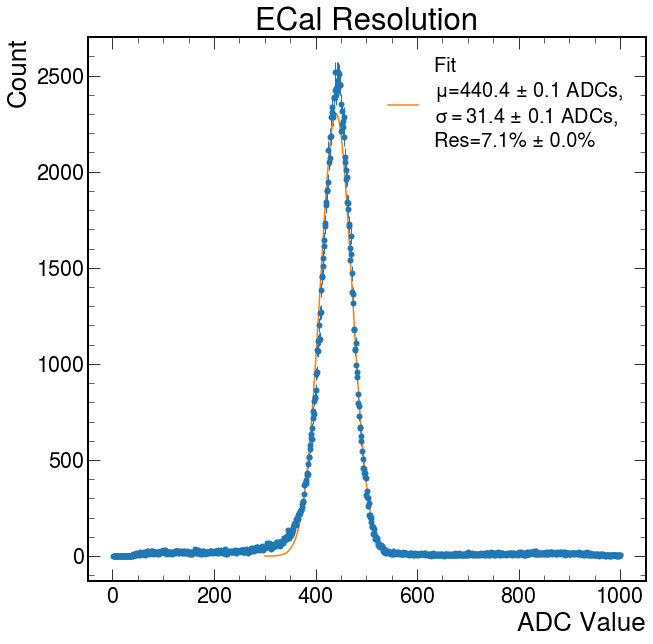

In [286]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
hep.style.use("CMS")

lowRange = 1
highRange = 1001
bins = 1000
lowFit = 300
highFit = 600


h, bins = np.histogram(ECalSumElectron, bins=bins, range=(lowRange,highRange))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

mask = (h > 0) & (bin_centers > lowFit) & (bin_centers < highFit)
initial_params = [max(h[mask]),np.mean(ECalSumElectron[ECalSumElectron > lowFit]),np.std(ECalSumElectron[ECalSumElectron > lowFit])]

m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
A_err = errors['A']
mu_err = errors['mu']
sigma_err = errors['sigma']

x = np.linspace(lowFit, highFit, 2000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = sigma_fit/mu_fit
res = np.sqrt((100*res)**2 - 1.8**2)

# Step 1: Calculate r and its error
r = sigma_fit / mu_fit
delta_r = r * np.sqrt((sigma_err / sigma_fit)**2 + (mu_err / mu_fit)**2)

# Step 2: Calculate s and its error
s = 100 * r
delta_s = 100 * delta_r

# Step 3: Calculate res and its error
res = np.sqrt(s**2 - 1.8**2)
delta_res = (s / np.sqrt(s**2 - 1.8**2)) * delta_s

x = np.linspace(lowFit, highFit, 1500)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100 * sigma_fit/mu_fit

plt.plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f ADCs, \n$\sigma=$%2.1f ± %2.1f ADCs, \nRes=%2.1f%% ± %2.1f%%'%(mu_fit, mu_err, sigma_fit, sigma_err, res, delta_res))
plt.legend(loc='upper right', fontsize=20)   

print("Mean: " + str(mu_fit))
print("Mean Error: " + str(mu_err))
print("Resolution: " + str(res))
print("Resolution Error: " + str(delta_res))

ElectronECut = (ECalSumElectron < ( mu_fit + (3* sigma_fit))) & (ECalSumElectron > ( mu_fit - (3* sigma_fit)))
ElectronEcalCh = ElectronEcalCh[:, ElectronECut]
ECalSumElectron = ECalSumElectron[ElectronECut]

plt.title("ECal Resolution")
plt.xlabel("ADC Value")
plt.ylabel("Count")

#nomap_yield.append( )

In [287]:
evtCh_list = [[] for i in range(16)]
linx_reco = []
liny_reco = []
evtSum_list = []

# Calculate weighted positions
xy_coords = np.array([channel_to_xy(ch) for ch in range(16)])  # Precompute xy coordinates

# Weighted sums
weighted_x = (xy_coords[:, 0].reshape(16, 1) * ElectronEcalCh).sum(axis=0)
weighted_y = (xy_coords[:, 1].reshape(16, 1) * ElectronEcalCh).sum(axis=0)

# Calculate final positions
linx_reco = weighted_x / ECalSumElectron
liny_reco = weighted_y / ECalSumElectron

# Convert to numpy arrays
linx_reco = np.array(linx_reco)
liny_reco = np.array(liny_reco)

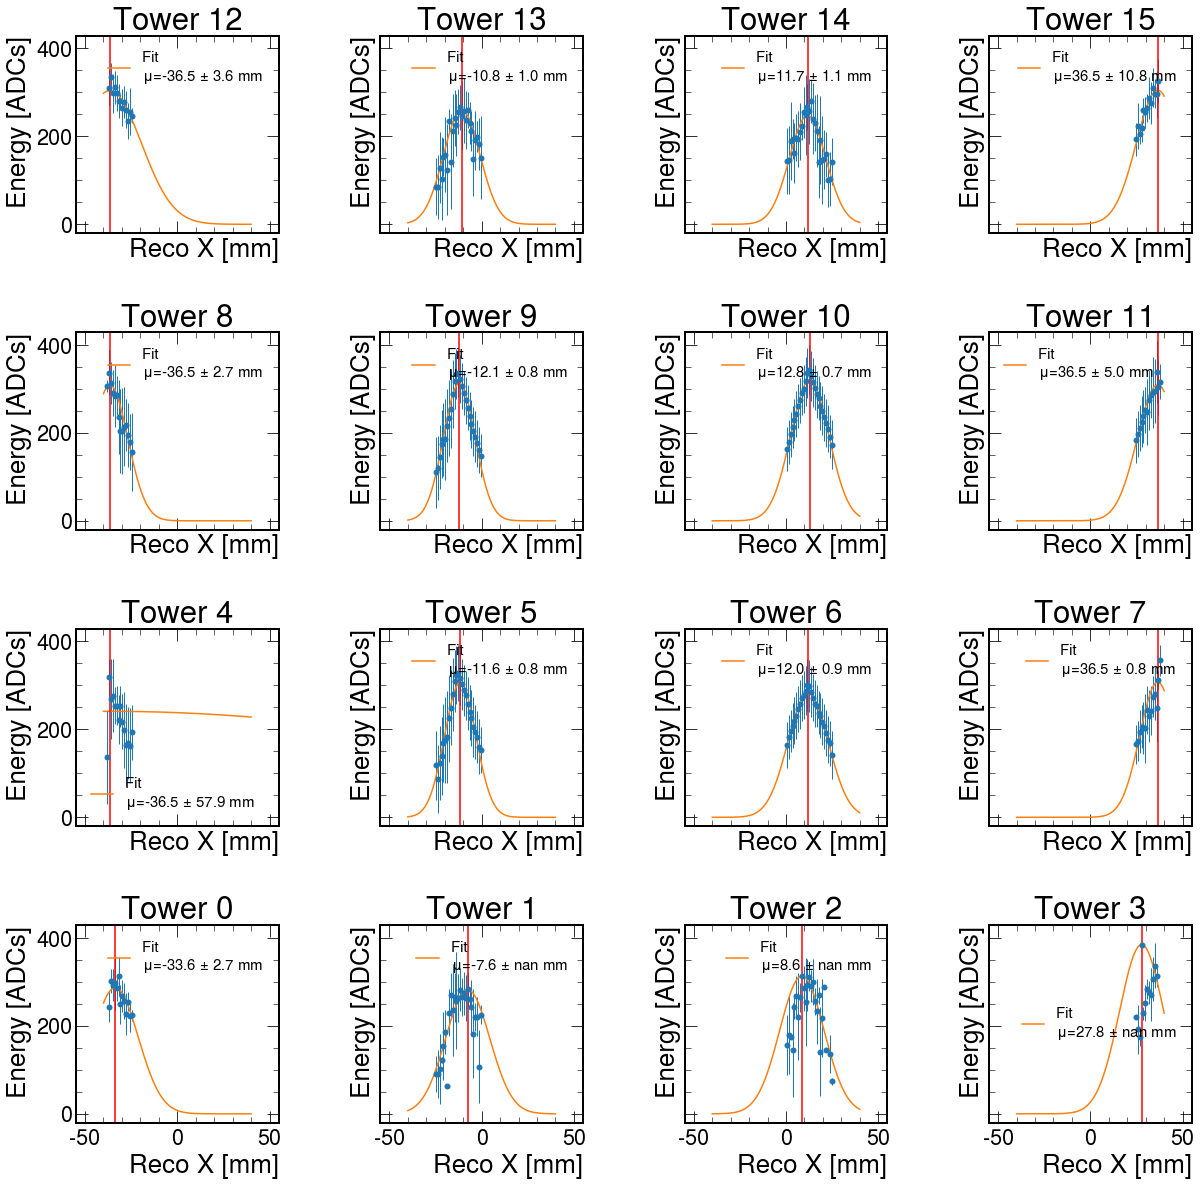

In [265]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True,sharex=True)
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
x_centers = []

for i, tower in enumerate(towers):
    
    ax = axes[i // 4, i % 4]
    
    span = np.linspace(-50, 50, 100)
    x_dist = []
    x_std = []
    
    # Define the grid size
    tower_size = 25
    grid_size = 4

    # Calculate the row and column based on the tower index
    row = (15 - tower) // grid_size
    col = tower % grid_size

    # Calculate the bounds
    xmin = (col - 2) * tower_size
    xmax = (col - 1) * tower_size
    ymax = (2 - row) * tower_size
    ymin = (1 - row) * tower_size

    # Create the condition
    tower_bounds = (linx_reco > xmin) & (linx_reco < xmax) & (liny_reco > ymin) & (liny_reco < ymax)
    
    for x_pos in span:
        mask = (linx_reco > (x_pos - 0.5)) & (linx_reco < (x_pos + 0.5)) 
        mask = mask & tower_bounds
        x_dist.append(np.mean(ElectronEcalCh[tower][mask]))
        x_std.append(np.std(ElectronEcalCh[tower][mask]))

    
    ax.errorbar(span, x_dist, yerr=x_std, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)
    
    x_dist = np.array(x_dist)
    x_std = np.array(x_std)
    span = np.array(span)
    mask = ~np.isnan(x_dist)
    initial_params = [max(x_dist[mask]), span[mask][np.argmax(x_dist[mask])], 12]  
    m = Minuit(LeastSquares(span[mask], x_dist[mask], x_std[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (-36.5, 36.5)
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    mu_err = errors['mu']
    x = np.linspace(-40, 40, 1500)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    ax.plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f mm'%(mu_fit, mu_err))
    ax.axvline(x=mu_fit, color='red')
    
    ax.legend(fontsize=15)
    
    ax.set_title("Tower "+str(tower))

    ax.set_xlabel("Reco X [mm]")
    ax.set_ylabel("Energy [ADCs]")
    
    x_centers.append(mu_fit)

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True,sharex=True)
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
y_centers = []

for i, tower in enumerate(towers):
    
    ax = axes[i // 4, i % 4]
    
    # Define the grid size
    tower_size = 25
    grid_size = 4

    # Calculate the row and column based on the tower index
    row = (15 - tower) // grid_size
    col = tower % grid_size

    # Calculate the bounds
    xmin = (col - 2) * tower_size
    xmax = (col - 1) * tower_size
    ymax = (2 - row) * tower_size
    ymin = (1 - row) * tower_size

    # Create the condition
    tower_bounds = (linx_reco > xmin) & (linx_reco < xmax) & (liny_reco > ymin) & (liny_reco < ymax)
    
    span = np.linspace(-50, 50, 100)
    y_dist = []
    y_std = []
    for y_pos in span:
        mask = (liny_reco > (y_pos - 0.5)) & (liny_reco < (y_pos + 0.5)) 
        mask = mask & tower_bounds
        y_dist.append(np.mean(ElectronEcalCh[tower][mask]))
        y_std.append(np.std(ElectronEcalCh[tower][mask]))
        
    
    ax.errorbar(span, y_dist, yerr=y_std, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)
    
    y_dist = np.array(y_dist)
    y_std = np.array(y_std)
    span = np.array(span)
    mask = ~np.isnan(y_dist)
    initial_params = [max(y_dist[mask]), span[mask][np.argmax(y_dist[mask])], 10]  
    m = Minuit(LeastSquares(span[mask], y_dist[mask], y_std[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (-36.5, 36.5)
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    mu_err = errors['mu']
    x = np.linspace(-50, 50, 1500)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    ax.plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f mm'%(mu_fit, mu_err))
    ax.legend(fontsize=15)
    ax.axvline(x=mu_fit, color='red')
    ax.set_title("Tower "+str(tower))

    ax.set_xlabel("Reco Y [mm]")
    ax.set_ylabel("Energy [ADCs]")
    y_centers.append(mu_fit)

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
fig.subplots_adjust(wspace = 0.5, hspace = 0.5)
towerMeans = []
towerErrs = []
width = 1

for idx, tower in enumerate(towers):
    x_pos = x_centers[idx]
    y_pos = y_centers[idx]
    ax = axs[idx // 4, idx% 4]
    posmask = (linx_reco > (x_pos - width)) & (linx_reco < (x_pos + width)) & (liny_reco > (y_pos - width)) & (liny_reco < (y_pos + width))

    h, bins = np.histogram(ElectronEcalCh[tower][posmask], range=(0,800), bins=50)

    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    errors = np.sqrt(h)
    ax.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)
    
    tower_dist = ElectronEcalCh[tower][posmask][ ElectronEcalCh[tower][posmask] > 250 ]
    initial_params = [max(h), np.mean(tower_dist), np.std(tower_dist)]
    
    m = Minuit(LeastSquares(bin_centers[h>0], h[h>0], errors[h>0], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.limits["mu"] = (300, 500)
    m.migrad()
    fitted_params = m.values
    errors = m.errors
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']
    mu_err = errors['mu']
    x = np.linspace(0, 600, 1500)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    ax.plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f ADCs'%(mu_fit, mu_err))
    ax.legend(fontsize=15, loc='upper right')

    ax.set_title("Tower "+str(tower))
    ax.set_xlabel("Energy [ADCs]")
    ax.set_ylabel("Count")
    if mu_err > 10:
        towerMeans.append(mu_fit)
    else:
        towerMeans.append(np.mean(tower_dist))
tower_calibrations = towerMeans / np.mean(towerMeans) 
print(tower_calibrations)

In [153]:
for i in range(len(tower_calibrations)):
    if (i != 5) & (i != 6) & (i != 9) & (i != 10):
        tower_calibrations[i] = 1
        
print(tower_calibrations)

[1.         1.         1.         1.         1.         0.98467949
 0.98724611 1.         1.         1.01032554 0.95173402 1.
 1.         1.         1.         1.        ]


In [288]:
towers = range(16)

tower_calibrations = np.array( [1.15, 1.06, 1.12, 0.97, 1, 1, 0.97, 1, 0.94, 0.94, 0.97, 0.97, 1.06, 0.97, 0.97, 1])

In [289]:
calibrated_ch = ElectronEcalCh.copy()
for i, tower in enumerate(towers):
    calibrated_ch[tower] = ElectronEcalCh[tower] / tower_calibrations[i]

# Convert to a numpy array if not already
calibrated_ch = np.array(calibrated_ch)
caliEvtSum = calibrated_ch.sum(axis=0)


# Calculate weights
log_values = np.log(calibrated_ch / caliEvtSum)
#3.8
w = np.maximum(log_values + 3.8, 0)

# Calculate weighted positions
xy_coords = np.array([channel_to_xy(ch) for ch in range(16)])  # Precompute xy coordinates

# Weighted sums
weighted_x = (xy_coords[:, 0].reshape(16, 1) * w).sum(axis=0)
weighted_y = (xy_coords[:, 1].reshape(16, 1) * w).sum(axis=0)

# Total weights
w_tot = w.sum(axis=0)

# Calculate final positions
calix_reco = weighted_x / w_tot
caliy_reco = weighted_y / w_tot

# Convert to numpy arrays
calix_reco = np.array(calix_reco)
caliy_reco = np.array(caliy_reco)

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


Mean: 440.5803465108327
Mean Error: 0.0752972100608062
Resolution: 7.037780947504585
Resolution Error: 0.014774125130421893


Text(0, 1, 'Count')

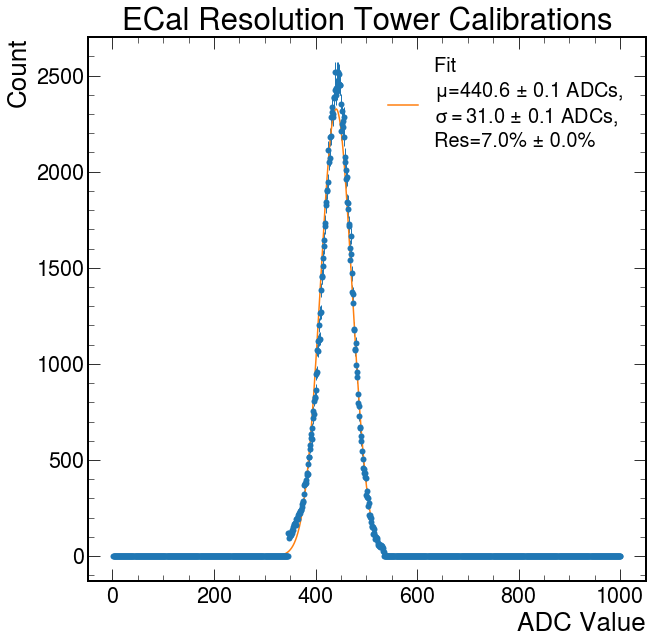

In [290]:
lowRange = 1
highRange = 1001
bins = 1000
lowFit = 300
highFit = 600


h, bins = np.histogram(ECalSumElectron, bins=bins, range=(lowRange,highRange))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue',
                      capsize=0, elinewidth=1, markeredgewidth=0)

mask = (h > 0) & (bin_centers > lowFit) & (bin_centers < highFit)
initial_params = [max(h[mask]),np.mean(ECalSumElectron[ECalSumElectron > lowFit]),np.std(ECalSumElectron[ECalSumElectron > lowFit])]

m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
errors = m.errors
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']
A_err = errors['A']
mu_err = errors['mu']
sigma_err = errors['sigma']

x = np.linspace(lowFit, highFit, 2000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = sigma_fit/mu_fit
res = np.sqrt((100*res)**2 - 1.8**2)

# Step 1: Calculate r and its error
r = sigma_fit / mu_fit
delta_r = r * np.sqrt((sigma_err / sigma_fit)**2 + (mu_err / mu_fit)**2)

# Step 2: Calculate s and its error
s = 100 * r
delta_s = 100 * delta_r

# Step 3: Calculate res and its error
res = np.sqrt(s**2 - 1.8**2)
delta_res = (s / np.sqrt(s**2 - 1.8**2)) * delta_s

x = np.linspace(lowFit, highFit, 1500)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
res = 100 * sigma_fit/mu_fit

plt.plot(x, y_fit, 'tab:orange', label='Fit \n$\mu$=%2.1f ± %2.1f ADCs, \n$\sigma=$%2.1f ± %2.1f ADCs, \nRes=%2.1f%% ± %2.1f%%'%(mu_fit, mu_err, sigma_fit, sigma_err, res, delta_res))
plt.legend(loc='upper right', fontsize=20)   

print("Mean: " + str(mu_fit))
print("Mean Error: " + str(mu_err))
print("Resolution: " + str(res))
print("Resolution Error: " + str(delta_res))

ElectronECut = (ECalSumElectron < ( mu_fit + (3* sigma_fit))) & (ECalSumElectron > ( mu_fit - (3* sigma_fit)))

ElectronEcalCh = ElectronEcalCh[:, ElectronECut]
ECalSumElectron = ECalSumElectron[ElectronECut]

caliElectronMean = mu_fit

plt.title("ECal Resolution Tower Calibrations")
plt.xlabel("ADC Value")
plt.ylabel("Count")

Text(0, 1, 'Reco Y [mm]')

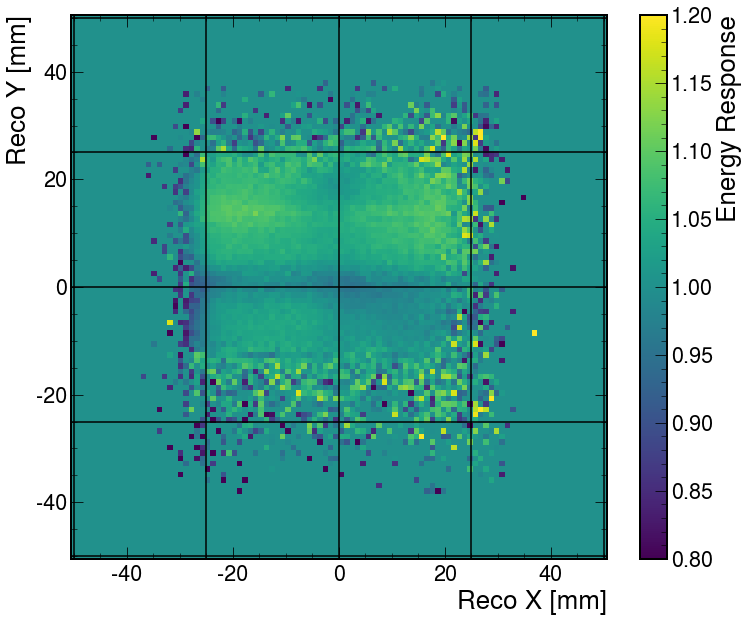

In [291]:
square_size = 25
grid_size = 4 * square_size

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
ym, xm = np.meshgrid(np.linspace(-50, 50, 100), np.linspace(-50, 50, 100))
zm = [[] for i in range(len(xm))] 
width = 0.5
for i, pos in enumerate(xm):
    for j, x_pos in enumerate(pos):
        y_pos = ym[i][j]
        mask = (calix_reco > (x_pos - width)) & (calix_reco < (x_pos + width)) & (caliy_reco > (y_pos - width)) & (caliy_reco < (y_pos + width))
        if(len(caliEvtSum[mask]) > 0):
            zm[i].append(np.mean(caliEvtSum[mask]) / caliElectronMean)
        else:
            zm[i].append(1)
zm = np.array(zm)

plt.pcolormesh(xm, ym, zm, vmin = 0.8, vmax = 1.2)


for xi in range(0, grid_size + 1, square_size):
    plt.axvline(x=xi - grid_size / 2, color='black')

for yi in range(0, grid_size + 1, square_size):
    plt.axhline(y=yi - grid_size / 2, color='black')
    
plt.colorbar(label="Energy Response")

plt.xlabel("Reco X [mm]")
plt.ylabel("Reco Y [mm]")

Text(0, 1, 'Reco Y [mm]')

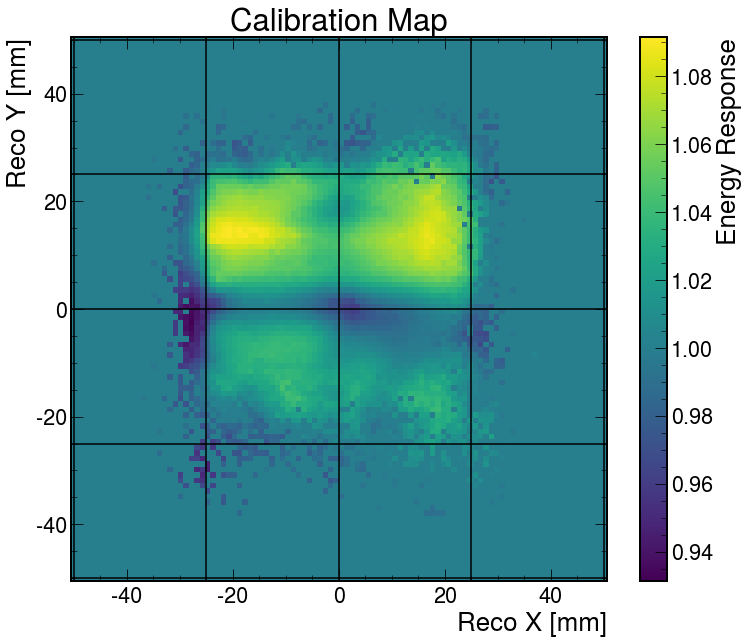

In [292]:
fig, axs = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

# Generate your 2D array as given
map_y, map_x = np.meshgrid(np.linspace(-50, 50, 100), np.linspace(-50, 50, 100))
z = [[] for i in range(len(map_x))]
width = 0.5

# Assuming calix_reco, lincaliy_reco, caliEvtSum, and caliElectronMean are defined
weight_map = np.zeros_like(map_x)

for i, pos in enumerate(map_x):
    for j, x_pos in enumerate(pos):
        y_pos = map_y[i][j]
        mask = (calix_reco > (x_pos - width)) & (calix_reco < (x_pos + width)) & (caliy_reco > (y_pos - width)) & (caliy_reco < (y_pos + width))
        weight_map[i, j] = len(caliEvtSum[mask])
        if weight_map[i, j] > 0:
            z[i].append(np.mean(caliEvtSum[mask]) / caliElectronMean)
        else:
            z[i].append(1)
z = np.array(z)

# Define the minimum and maximum radii
min_radius = 0.1
max_radius = 5

# Create the smoothed map
map_z_smoothed = np.zeros_like(z)

for i in range(z.shape[0]):
    for j in range(z.shape[1]):
        entries = weight_map[i, j]
        if entries > 0:
            # Map the number of entries to a radius between min_radius and max_radius
            radius = max_radius - (entries / np.max(weight_map) * (max_radius - min_radius))
            kernel = circular_kernel(int(radius))
            sub_z = z[max(i - int(radius), 0):min(i + int(radius) + 1, z.shape[0]),
                      max(j - int(radius), 0):min(j + int(radius) + 1, z.shape[1])]
            sub_z_padded = np.pad(sub_z, ((max(0, int(radius) - i), max(0, i + int(radius) + 1 - z.shape[0])),
                                          (max(0, int(radius) - j), max(0, j + int(radius) + 1 - z.shape[1]))), 
                                  'constant', constant_values=1)
            smoothed_value = convolve(sub_z_padded, kernel, mode='constant', cval=1)
            map_z_smoothed[i, j] = smoothed_value[int(radius), int(radius)]
        else:
            map_z_smoothed[i, j] = 1
            
for xi in range(0, grid_size + 1, square_size):
    plt.axvline(x=xi - grid_size / 2, color='black')

for yi in range(0, grid_size + 1, square_size):
    plt.axhline(y=yi - grid_size / 2, color='black')
    
# Plot the smoothed map
plt.pcolormesh(map_x, map_y, map_z_smoothed)
plt.colorbar(label="Energy Response")
plt.title("Calibration Map")
plt.xlabel("Reco X [mm]")
plt.ylabel("Reco Y [mm]")

In [293]:
calibrations_dict = {
    'towers': towers,
    'tower_calibrations': tower_calibrations,
    'x_map': map_x,
    'y_map': map_y,
    'calibration_map': map_z_smoothed
}

with open(output_file_name, 'wb') as file:
    pickle.dump(calibrations_dict, file)

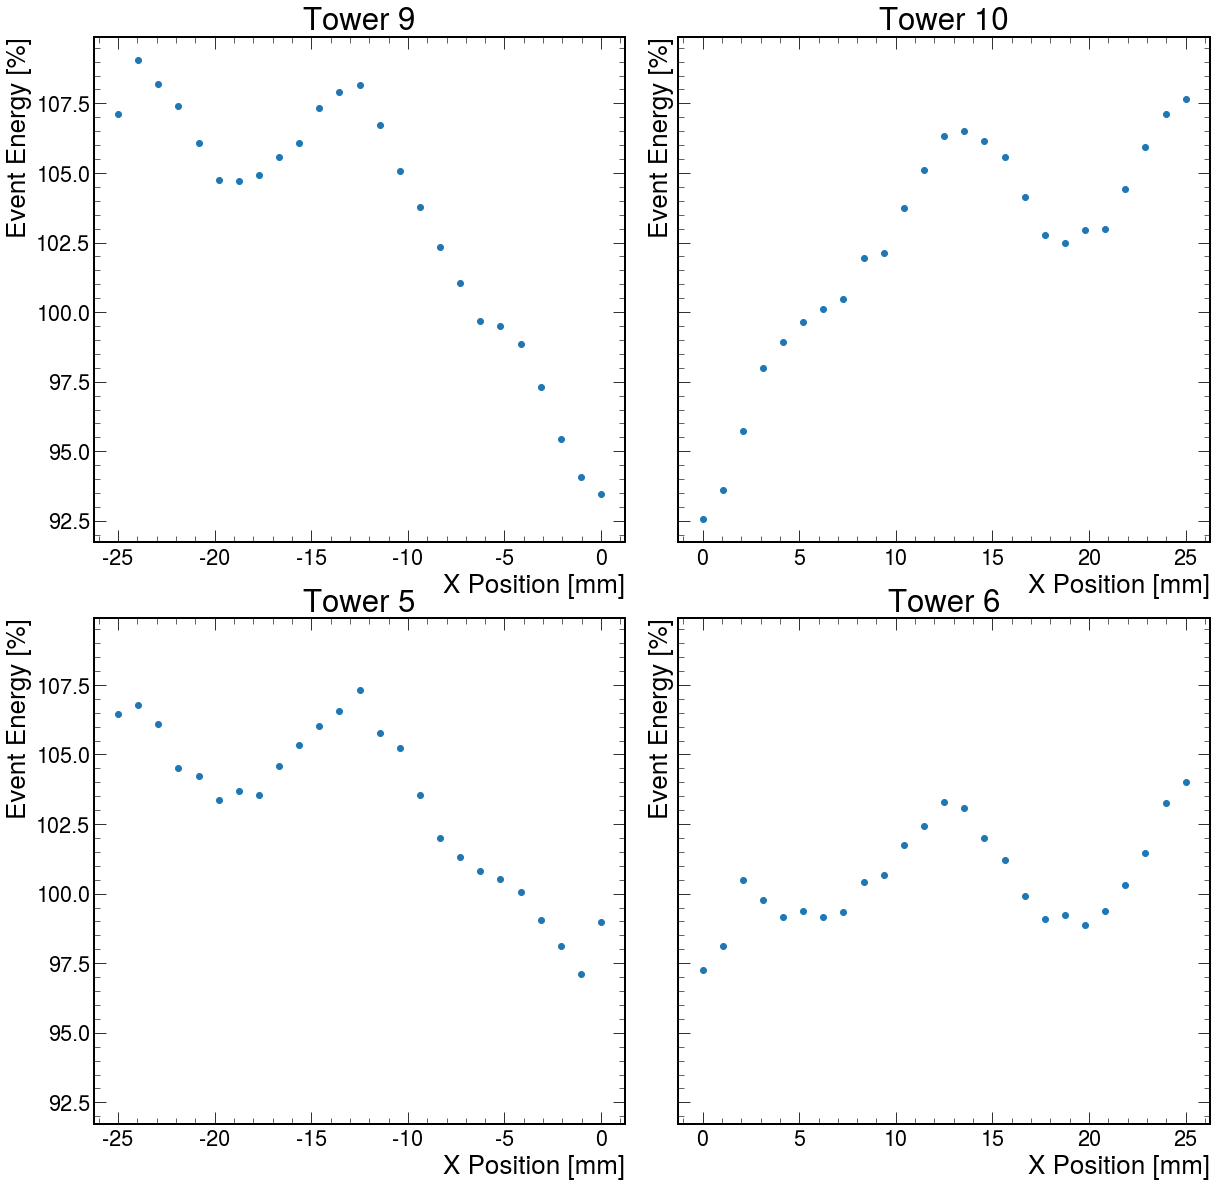

In [233]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
fig.subplots_adjust(wspace = 0.1, hspace = 0.15)

towers = np.array([9, 10, 5, 6])

for i, tower in enumerate(towers):
    ax = axes[i // 2, i % 2]
    x_dist = []
    x_std = []
    
    
    
    # Define the grid size
    tower_size = 25
    grid_size = 4

    # Calculate the row and column based on the tower index
    row = (15 - tower) // grid_size
    col = tower % grid_size

    # Calculate the bounds
    xmin = (col - 2) * tower_size
    xmax = (col - 1) * tower_size
    ymax = (2 - row) * tower_size
    ymin = (1 - row) * tower_size
    
    span = np.linspace(xmin, xmax, 25)

    # Create the condition
    tower_bounds = (calix_reco > xmin) & (calix_reco < xmax) & (caliy_reco > ymin) & (caliy_reco < ymax)
    
    for x_pos in span:
        mask = (calix_reco > (x_pos - 0.5)) & (calix_reco < (x_pos + 0.5)) 
        mask = mask & tower_bounds
        x_dist.append(100*np.mean(caliEvtSum[mask])/ caliElectronMean)
        x_std.append(np.std(caliEvtSum[mask]))

    ax.scatter(span, x_dist)
    ax.set_title("Tower "+str(tower))
    ax.set_xlabel("X Position [mm]")
    ax.set_ylabel("Event Energy [%]")
    


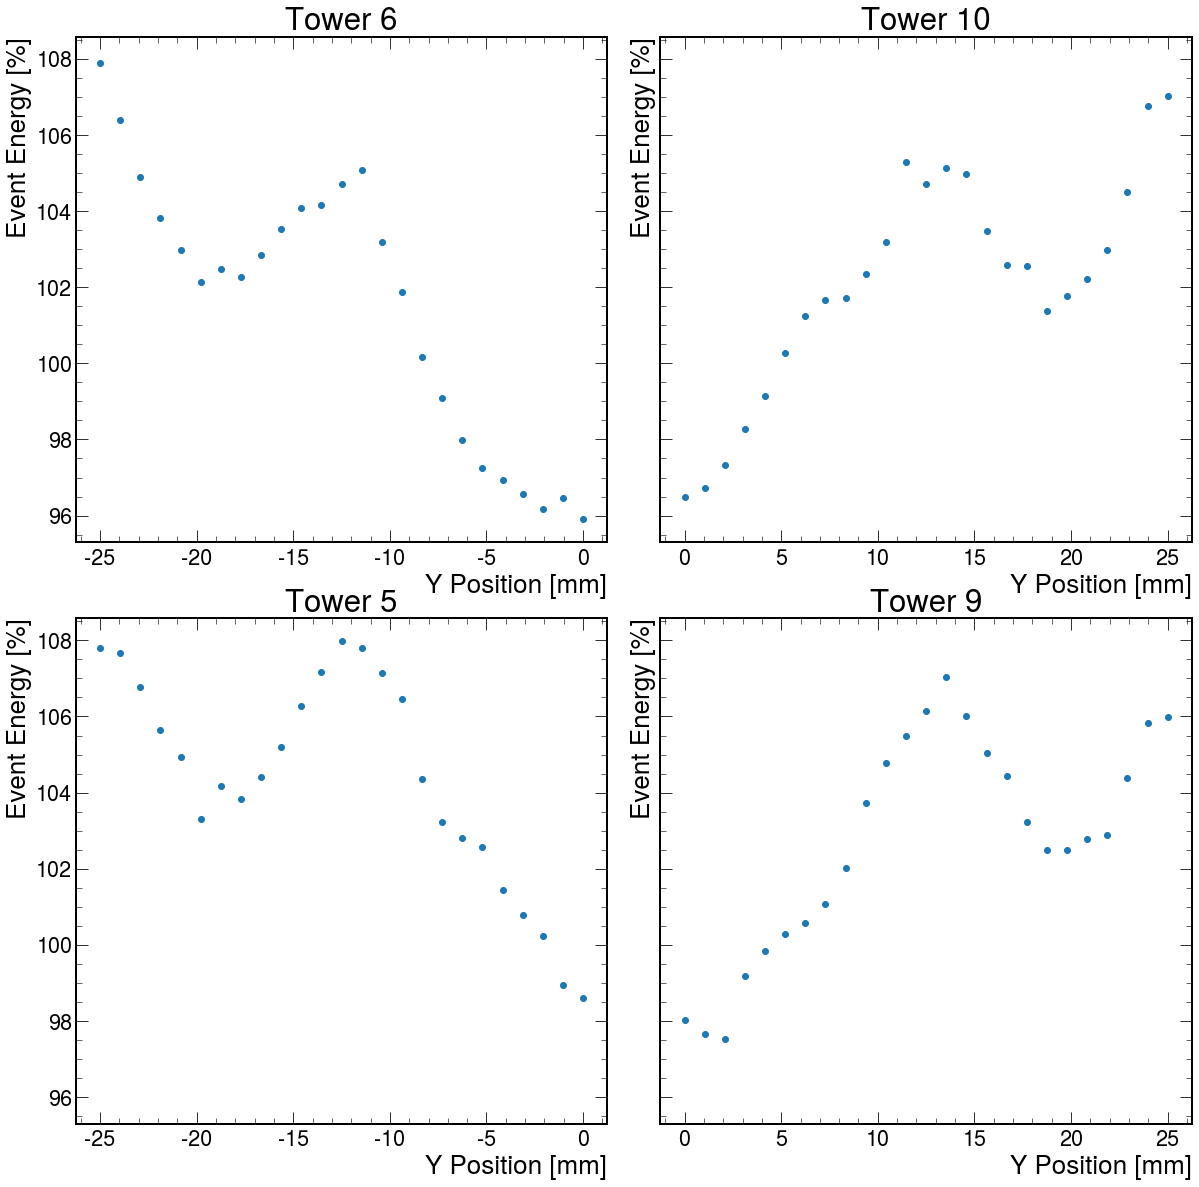

In [236]:
fig, axes = plt.subplots(2, 2, figsize=(20, 20), sharey=True)
fig.subplots_adjust(wspace = 0.1, hspace = 0.15)

towers = np.array([6, 10, 5, 9])

for i, tower in enumerate(towers):
    ax = axes[i // 2, i % 2]
    y_dist = []
    y_std = []
    
    # Define the grid size
    tower_size = 25
    grid_size = 4

    # Calculate the row and column based on the tower index
    row = (15 - tower) // grid_size
    col = tower % grid_size

    # Calculate the bounds
    xmin = (col - 2) * tower_size
    xmax = (col - 1) * tower_size
    ymax = (2 - row) * tower_size
    ymin = (1 - row) * tower_size
    
    span = np.linspace(ymin, ymax, 25)

    # Create the condition
    tower_bounds = (calix_reco > xmin) & (calix_reco < xmax) & (caliy_reco > ymin) & (caliy_reco < ymax)
    
    for y_pos in span:
        mask = (caliy_reco > (y_pos - 0.5)) & (caliy_reco < (y_pos + 0.5)) 
        mask = mask & tower_bounds
        y_dist.append(100*np.mean(caliEvtSum[mask])/ caliElectronMean)
        y_std.append(np.std(caliEvtSum[mask]))
    
    ax.scatter(span, y_dist)
    ax.set_title("Tower "+str(tower))
    ax.set_xlabel("Y Position [mm]")
    ax.set_ylabel("Event Energy [%]")

Text(0, 1, 'Reco Y [mm]')

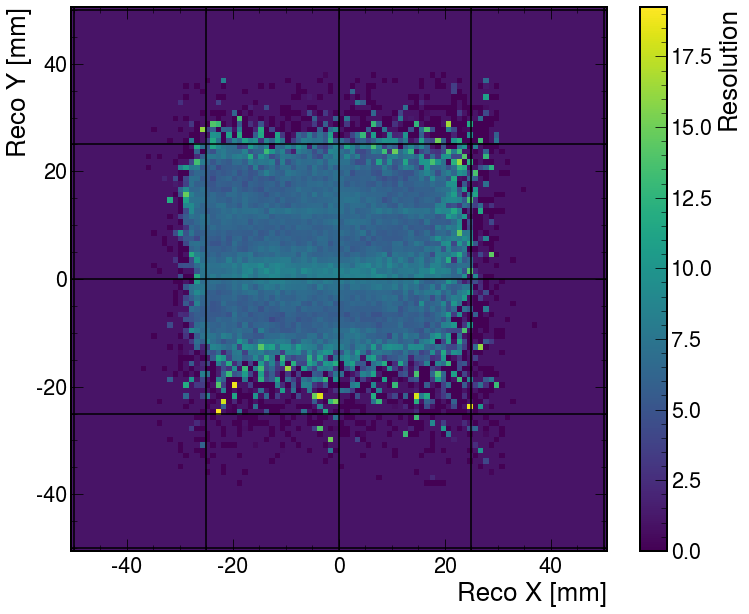

In [255]:
square_size = 25
grid_size = 4 * square_size

fig, axs = plt.subplots(1, 1, figsize=(12, 10))
ym, xm = np.meshgrid(np.linspace(-50, 50, 100), np.linspace(-50, 50, 100))
zm = [[] for i in range(len(xm))] 
width = 0.5
for i, pos in enumerate(xm):
    for j, x_pos in enumerate(pos):
        y_pos = ym[i][j]
        mask = (calix_reco > (x_pos - width)) & (calix_reco < (x_pos + width)) & (caliy_reco > (y_pos - width)) & (caliy_reco < (y_pos + width))
        if(len(caliEvtSum[mask]) > 0):
            zm[i].append(100 * np.std(caliEvtSum[mask]) / np.mean(caliEvtSum[mask]) )
        else:
            zm[i].append(1)
zm = np.array(zm)

plt.pcolormesh(xm, ym, zm)


for xi in range(0, grid_size + 1, square_size):
    plt.axvline(x=xi - grid_size / 2, color='black')

for yi in range(0, grid_size + 1, square_size):
    plt.axhline(y=yi - grid_size / 2, color='black')
    
plt.colorbar(label="Resolution")

plt.xlabel("Reco X [mm]")
plt.ylabel("Reco Y [mm]")